In [ ]:
import sys
import os

from mmengine.registry import init_default_scope

# Add project root to Python path and initialize MMDetection scope
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if (project_root not in sys.path):
    sys.path.insert(0, project_root)
os.chdir(project_root)
init_default_scope('mmdet')


# Prediction Match Analysis Using Confusion Matrix

This notebook analyzes model predictions and matches using the hierarchical confusion matrix code. For each model, it loads the config, predictions, and dataset, computes matches between ground truth and detections, and calculates the hierarchical F1 (HF1) score for each match.

---

## 1. Import Required Libraries

Import necessary libraries such as `pickle`, `pandas`, `numpy`, and the confusion matrix functions from the provided code.

In [2]:

import pickle
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mmengine import Config
from mmdet.registry import DATASETS
from hod.utils.tree import HierarchyTree

# Import confusion matrix functions
from tools.analysis_tools.confusion_matrix import (
    calculate_confusion_matrix,
    analyze_per_img_dets,
    hierarchical_prf_metric
)


## 2. Project Setup

Set up the project environment by adding the project root to the Python path and initializing the required scope.

## 3. Load Model Configurations and Results

Load the model configuration files, prediction results (`.pkl` files), and dataset metadata. Specify the models to analyze below.

In [3]:
# Define models to analyze (update paths as needed)
MODELS_TO_ANALYZE = {
    "DINO": {
        "config": "configs/hod/models/dino/dino-r50_improved_8xb2-36e_aircraft-func.py",
        "results_path": "outputs/inference/dino-r50_improved_8xb2-36e_aircraft-func.pkl"
    },
    "DINO-H": {
        "config": "configs/hod/models/hierarchical_dino_func_sweep/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "results_path": "outputs/inference/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func-single.pkl"
    },
}

model_data = {}
for model_name, model_info in MODELS_TO_ANALYZE.items():
    print(f"Loading model: {model_name}")
    config_path = model_info['config']
    results_path = Path(model_info['results_path'])
    if not results_path.exists():
        print(f"  WARNING: Results file not found, skipping: {results_path}")
        continue
    cfg = Config.fromfile(config_path)
    dataset = DATASETS.build(cfg.test_dataloader.dataset)
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    model_data[model_name] = {
        'cfg': cfg,
        'dataset': dataset,
        'results': results
    }


Loading model: DINO
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading model: DINO-H
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading model: DINO-H
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [81]:
model_data.get('DINO', {}).get('results', None)[0]

{'img_id': 0,
 'scale_factor': (0.30864197530864196, 0.30864197530864196),
 'img_path': 'data/aircraft/dataset/f0055552c8a0538a76b175765f443b97.jpg',
 'batch_input_shape': (800, 1200),
 'img_shape': (800, 1200),
 'pad_shape': (800, 1200),
 'ori_shape': (2592, 3888),
 'pred_instances': {'bboxes': tensor([[1644.9794, 1103.5391, 1767.0953, 1138.0817],
          [1644.9794, 1103.5391, 1767.0953, 1138.0817],
          [1645.8562, 1101.5903, 1767.5955, 1136.9801],
          ...,
          [1645.8562, 1101.5903, 1767.5955, 1136.9801],
          [1645.8562, 1101.5903, 1767.5955, 1136.9801],
          [   1.9249,  463.3344,    5.7681,  544.0934]]),
  'scores': tensor([0.8991, 0.0149, 0.0139, 0.0138, 0.0132, 0.0125, 0.0124, 0.0123, 0.0114,
          0.0106, 0.0102, 0.0100, 0.0096, 0.0095, 0.0093, 0.0086, 0.0086, 0.0084,
          0.0084, 0.0082, 0.0074, 0.0072, 0.0067, 0.0064, 0.0063, 0.0061, 0.0058,
          0.0057, 0.0055, 0.0052, 0.0050, 0.0049, 0.0048, 0.0048, 0.0047, 0.0047,
          0.00

## 4. Calculate Confusion Matrix and Matches

Use the `calculate_confusion_matrix` function to compute the confusion matrix and extract matches for each ground truth and detection.

In [86]:
# For each model, compute matches and HF1 scores per ground truth
all_model_matches = {}
for model_name, data in model_data.items():
    print(f"Processing matches for model: {model_name}")
    dataset = data['dataset']
    results = data['results']
    class_names = dataset.metainfo['classes']
    taxonomy = dataset.metainfo['taxonomy']
    tree = HierarchyTree(taxonomy)
    path_lookup = {name: set(tree.get_path(name)) for name in tree.class_to_node.keys()}

    matches = []
    for idx, per_img_res in tqdm(enumerate(results), total=len(results), desc=f"Images ({model_name})"):
        res_bboxes = per_img_res['pred_instances']
        gts = dataset.get_data_info(idx)['instances']
        # Prepare GT and detection arrays
        gt_bboxes = np.array([gt['bbox'] for gt in gts]) if gts else np.empty((0, 4))
        gt_labels = np.array([gt['bbox_label'] for gt in gts]) if gts else np.empty((0,))
        det_scores = res_bboxes['scores'].numpy()
        score_thr = 0.3
        score_mask = det_scores >= score_thr
        det_bboxes = res_bboxes['bboxes'].numpy()[score_mask]
        det_labels = res_bboxes['labels'].numpy()[score_mask]
        det_scores = det_scores[score_mask]
        # Sort detections by score
        sort_inds = np.argsort(-det_scores)
        det_bboxes = det_bboxes[sort_inds]
        det_labels = det_labels[sort_inds]
        det_scores = det_scores[sort_inds]
        D = len(det_labels)
        G = len(gt_labels)
        label_to_name = {i: name for i, name in enumerate(class_names)}
        # Matching logic (similar to analyze_per_img_dets)
        gtm_idx = -np.ones(G, dtype=int)
        gt_hf1 = np.zeros(G)
        d_matched = np.zeros(D, dtype=bool)
        detections_to_process = list(range(D))
        ious = None
        if D > 0 and G > 0:
            from mmdet.evaluation import bbox_overlaps
            ious = bbox_overlaps(det_bboxes, gt_bboxes)
        while detections_to_process:
            dind = detections_to_process.pop(0)
            d_label_name = label_to_name.get(det_labels[dind]) if D > 0 else None
            if not d_label_name:
                continue
            valid_gt_indices = []
            if ious is not None:
                valid_gt_mask = ious[dind, :] >= 0.5
                valid_gt_indices = np.where(valid_gt_mask)[0]
            if len(valid_gt_indices) == 0:
                continue
            best_boost = 1e-9
            best_gt_match_idx = -1
            best_iou = -1.0
            for gind in valid_gt_indices:
                gt_label_name = label_to_name.get(int(gt_labels[gind]))
                if not gt_label_name:
                    continue
                metrics = hierarchical_prf_metric(path_lookup, d_label_name, gt_label_name, return_paths=True)
                potential_hf1 = metrics.get('hf1', 0.0) if isinstance(metrics, dict) else 0.0
                existing_hf1 = gt_hf1[gind]
                boost = potential_hf1 - existing_hf1
                if boost > best_boost or (boost == best_boost and ious[dind, gind] > best_iou):
                    best_boost = boost
                    best_gt_match_idx = gind
                    best_iou = ious[dind, gind]
            if best_gt_match_idx != -1:
                prev_d_idx = gtm_idx[best_gt_match_idx]
                if prev_d_idx != -1:
                    d_matched[prev_d_idx] = False
                    detections_to_process.insert(0, int(prev_d_idx))
                gtm_idx[best_gt_match_idx] = dind
                gt_hf1[best_gt_match_idx] = best_boost + gt_hf1[best_gt_match_idx]
                d_matched[dind] = True
        # Collect matches for this image
        for gind in range(G):
            gt_label_name = label_to_name.get(int(gt_labels[gind]))
            # img_info = dataset.get_data_info(idx)
            scale_factor = results[idx].get('scale_factor',  (1.0, 1.0))
            match_info = {
                'image_idx': idx,
                'gt_label': gt_label_name,
                'gt_bbox': gt_bboxes[gind] if G > 0 else None,
                'matched': False,
                'dt_label': None,
                'dt_bbox': None,
                'hf1': 0.0,
                'scale_factor': scale_factor
            }
            dind = gtm_idx[gind]
            if dind != -1:
                dt_label_name = label_to_name.get(int(det_labels[dind]))
                match_info['matched'] = True
                match_info['dt_label'] = dt_label_name
                match_info['dt_bbox'] = det_bboxes[dind]
                metrics = hierarchical_prf_metric(path_lookup, dt_label_name, gt_label_name, return_paths=True)
                match_info['hf1'] = metrics.get('hf1', 0.0) if isinstance(metrics, dict) else 0.0
            matches.append(match_info)
    all_model_matches[model_name] = matches


Processing matches for model: DINO


Images (DINO): 100%|██████████| 1295/1295 [00:00<00:00, 16179.85it/s]


Processing matches for model: DINO-H


Images (DINO-H): 100%|██████████| 1295/1295 [00:00<00:00, 16049.47it/s]


## 5. Generate DataFrame with Predictions and Matches

Create a DataFrame containing predictions, ground truth labels, detection labels, and the corresponding hierarchical F1 (HF1) scores for each model.

In [87]:
# Create and display DataFrame for each model
model_dfs = {}
for model_name, matches in all_model_matches.items():
    df = pd.DataFrame(matches)
    model_dfs[model_name] = df
    print(f"\nModel: {model_name}")
    display(df.head())



Model: DINO


image_idx gt_label                   gt_bbox  matched dt_label  \
0          0      F35  [1643, 1105, 1767, 1138]     True      F35   
1          1     C130         [0, 0, 1200, 800]     True    A400M   
2          2     Su57       [121, 22, 439, 315]     True     Su57   
3          3    A400M      [36, 227, 1199, 509]     True    A400M   
4          4      C17     [0, 1491, 2827, 2423]    False     None   

                                        dt_bbox       hf1  \
0  [1644.9794, 1103.5391, 1767.0953, 1138.0817]  1.000000   
1      [0.8605957, 1.4009476, 1199.6324, 800.0]  0.727273   
2  [121.86322, 21.321186, 438.31952, 315.28784]  1.000000   
3    [33.81734, 227.38206, 1198.8541, 508.6627]  1.000000   
4                                          None  0.000000   

                                 scale_factor  
0  (0.30864197530864196, 0.30864197530864196)  
1                                  (1.0, 1.0)  
2      (2.050909090909091, 2.051282051282051)  
3                                  (1.0, 1.0)  
4            (0.29296875, 0.2929329915781765)


Model: DINO-H


image_idx gt_label                   gt_bbox  matched dt_label  \
0          0      F35  [1643, 1105, 1767, 1138]     True      F35   
1          1     C130         [0, 0, 1200, 800]     True    A400M   
2          2     Su57       [121, 22, 439, 315]     True     Su57   
3          3    A400M      [36, 227, 1199, 509]     True    A400M   
4          4      C17     [0, 1491, 2827, 2423]     True      UAV   

                                        dt_bbox       hf1  \
0  [1645.8973, 1104.4956, 1768.3811, 1139.9594]  1.000000   
1  [0.85719824, 0.4832983, 1199.6487, 799.6845]  0.727273   
2   [121.54116, 21.028439, 438.97018, 315.4024]  1.000000   
3   [34.589565, 227.93024, 1196.9343, 508.4009]  1.000000   
4        [0.0, 1494.9852, 4090.2734, 2444.9443]  0.444444   

                                 scale_factor  
0  (0.30864197530864196, 0.30864197530864196)  
1                                  (1.0, 1.0)  
2      (2.050909090909091, 2.051282051282051)  
3                                  (1.0, 1.0)  
4            (0.29296875, 0.2929329915781765)

## 6. Visualize Predictions and Matches

Generate visualizations such as bar charts or tables to analyze the predictions and matches for each model.


Model: DINO - Match Statistics


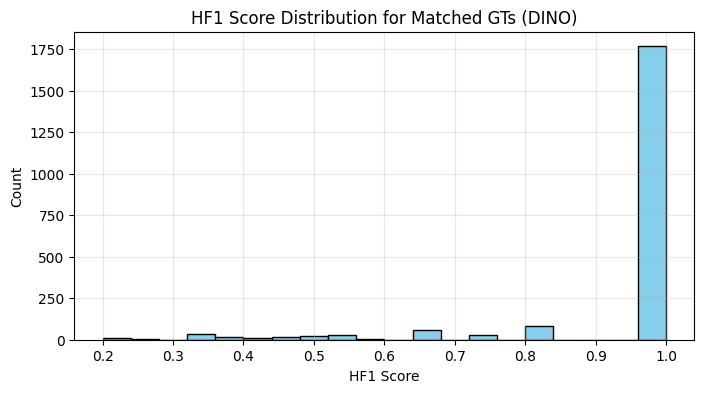

Top 10 Matches with Highest HF1:


image_idx gt_label dt_label  hf1
2293       1292   EF2000   EF2000  1.0
0             0      F35      F35  1.0
2292       1291     Mi28     Mi28  1.0
2             2     Su57     Su57  1.0
3             3    A400M    A400M  1.0
6             5       E2       E2  1.0
7             6       U2       U2  1.0
8             7     Su57     Su57  1.0
9             8      A10      A10  1.0
2291       1290     C130     C130  1.0


Model: DINO-H - Match Statistics


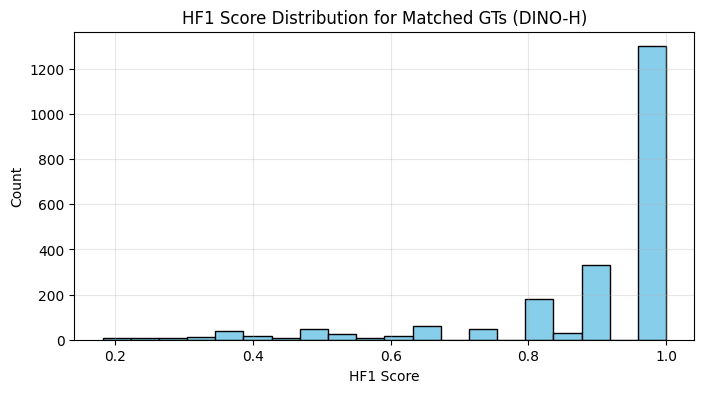

Top 10 Matches with Highest HF1:


image_idx gt_label dt_label  hf1
2292       1291     Mi28     Mi28  1.0
0             0      F35      F35  1.0
2291       1290     C130     C130  1.0
2             2     Su57     Su57  1.0
3             3    A400M    A400M  1.0
2290       1289      F16      F16  1.0
6             5       E2       E2  1.0
7             6       U2       U2  1.0
8             7     Su57     Su57  1.0
9             8      A10      A10  1.0

In [88]:
# Visualize HF1 scores and match statistics for each model
for model_name, df in model_dfs.items():
    print(f"\nModel: {model_name} - Match Statistics")
    # Bar chart: Distribution of HF1 scores for matched GTs
    matched_df = df[df['matched']]
    plt.figure(figsize=(8, 4))
    plt.hist(matched_df['hf1'], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"HF1 Score Distribution for Matched GTs ({model_name})")
    plt.xlabel("HF1 Score")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    plt.show()
    # Table: Top matches with highest HF1
    top_matches = matched_df.sort_values('hf1', ascending=False).head(10)
    print("Top 10 Matches with Highest HF1:")
    display(top_matches[['image_idx', 'gt_label', 'dt_label', 'hf1']])


In [89]:
# Merge model DataFrames on image_idx and gt_label, including gt_bbox
# Ensure gt_bbox is included from one model (they should be identical for all models)
dfs_renamed = []
for i, (model_name, df) in enumerate(model_dfs.items()):
    cols = ['image_idx', 'gt_label', 'dt_label', 'dt_bbox', 'hf1', 'scale_factor']
    if i == 0 and 'gt_bbox' in df.columns:
        cols = ['image_idx', 'gt_label', 'gt_bbox', 'dt_label', 'dt_bbox', 'hf1', 'scale_factor']
    df_model = df[cols].copy()
    rename_dict = {
        'dt_label': f'dt_label_{model_name}',
        'dt_bbox': f'dt_bbox_{model_name}',
        'hf1': f'hf1_{model_name}',
        'scale_factor': f'scale_factor_{model_name}'
    }
    if i == 0 and 'gt_bbox' in df.columns:
        rename_dict['gt_bbox'] = 'gt_bbox'
    df_model = df_model.rename(columns=rename_dict)
    dfs_renamed.append(df_model)

from functools import reduce
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['image_idx', 'gt_label'], how='outer'), dfs_renamed)
df_merged['hf1_diff'] = df_merged['hf1_DINO'] - df_merged['hf1_DINO-H']
df_merged['gt_bbox_tuple'] = df_merged['gt_bbox'].apply(lambda x: tuple(x) if isinstance(x, (list, np.ndarray)) else x)
df_merged = df_merged.drop_duplicates(subset=['image_idx', 'gt_label', 'gt_bbox_tuple']).reset_index(drop=True)
df_merged = df_merged.drop(columns=['gt_bbox_tuple'])

print("Merged DataFrame with GT, GT bbox, detections, and scale_factor from all models:")
display(df_merged.head())


Merged DataFrame with GT, GT bbox, detections, and scale_factor from all models:


image_idx gt_label                   gt_bbox dt_label_DINO  \
0          0      F35  [1643, 1105, 1767, 1138]           F35   
1          1     C130         [0, 0, 1200, 800]         A400M   
2          2     Su57       [121, 22, 439, 315]          Su57   
3          3    A400M      [36, 227, 1199, 509]         A400M   
4          4     C130  [1182, 2210, 4096, 2442]          None   

                                   dt_bbox_DINO  hf1_DINO  \
0  [1644.9794, 1103.5391, 1767.0953, 1138.0817]  1.000000   
1      [0.8605957, 1.4009476, 1199.6324, 800.0]  0.727273   
2  [121.86322, 21.321186, 438.31952, 315.28784]  1.000000   
3    [33.81734, 227.38206, 1198.8541, 508.6627]  1.000000   
4                                          None  0.000000   

                            scale_factor_DINO dt_label_DINO-H  \
0  (0.30864197530864196, 0.30864197530864196)             F35   
1                                  (1.0, 1.0)           A400M   
2      (2.050909090909091, 2.051282051282051)            Su57   
3                                  (1.0, 1.0)           A400M   
4            (0.29296875, 0.2929329915781765)            None   

                                 dt_bbox_DINO-H  hf1_DINO-H  \
0  [1645.8973, 1104.4956, 1768.3811, 1139.9594]    1.000000   
1  [0.85719824, 0.4832983, 1199.6487, 799.6845]    0.727273   
2   [121.54116, 21.028439, 438.97018, 315.4024]    1.000000   
3   [34.589565, 227.93024, 1196.9343, 508.4009]    1.000000   
4                                          None    0.000000   

                          scale_factor_DINO-H  hf1_diff  
0  (0.30864197530864196, 0.30864197530864196)       0.0  
1                                  (1.0, 1.0)       0.0  
2      (2.050909090909091, 2.051282051282051)       0.0  
3                                  (1.0, 1.0)       0.0  
4            (0.29296875, 0.2929329915781765)       0.0

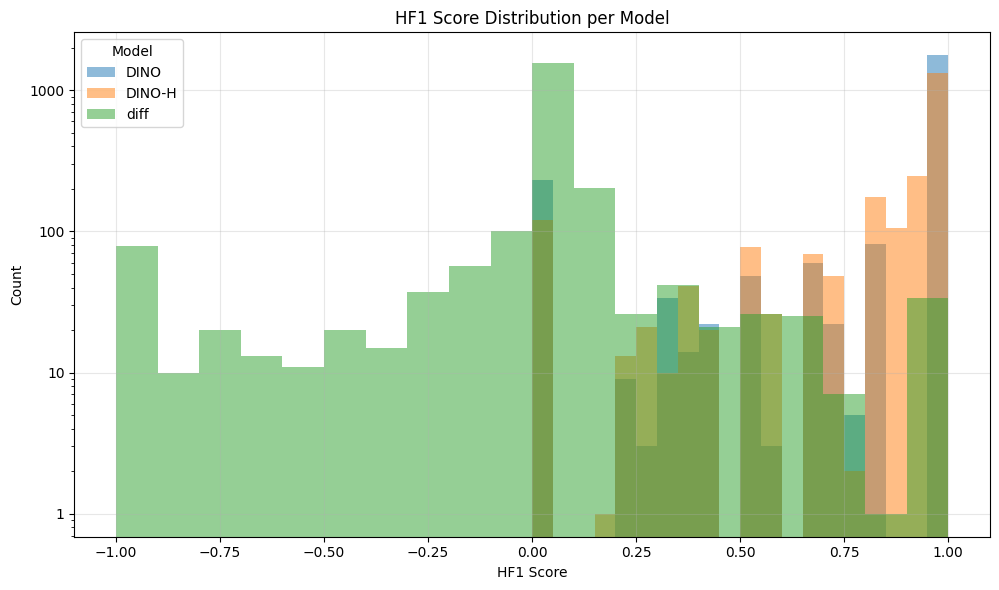

In [90]:
# Visualize HF1 score distributions for each model from merged DataFrame with log-scaled y-axis (show normal values)
plt.figure(figsize=(10, 6))
for model in [col.replace('hf1_', '') for col in df_merged.columns if col.startswith('hf1_')]:
    # if model == 'diff':
    #     continue
    scores = df_merged[f'hf1_{model}'].dropna()
    plt.hist(scores, bins=20, alpha=0.5, label=model)
plt.title('HF1 Score Distribution per Model')
plt.xlabel('HF1 Score')
plt.ylabel('Count')
plt.yscale('log')
plt.legend(title='Model')
plt.grid(True, alpha=0.3)
plt.tight_layout()
from matplotlib.ticker import ScalarFormatter
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.show()

In [ ]:
# interesting_df = df_merged[
#     (0.0 < df_merged['hf1_DINO']) & (df_merged['hf1_DINO'] < 1.0) & \
#         (0.0 < df_merged['hf1_DINO-H']) & (df_merged['hf1_DINO-H'] < 1.0) #  < 1.0
# ].copy()

# # Sort interesting_df by hf1_diff and show the top and bottom cases
# sorted_df = interesting_df.sort_values('hf1_diff', ascending=False)

# print("Top 5 cases where DINO outperforms DINO-H (highest positive diff):")
# display(sorted_df.head(5)[['image_idx', 'gt_label', 'hf1_DINO', 'hf1_DINO-H', 'hf1_diff']])

# print("Top 5 cases where DINO-H outperforms DINO (highest negative diff):")
# display(sorted_df.tail(5)[['image_idx', 'gt_label', 'hf1_DINO', 'hf1_DINO-H', 'hf1_diff']])

# Filter out image_idx where any model has hf1 == 0.0 for any GT in that image
valid_image_idxs = (
    df_merged
    .groupby('image_idx')
    .filter(lambda group: (group['hf1_DINO'] > 0.0).all() and (group['hf1_DINO-H'] > 0.0).all() \
            and (group['hf1_DINO'] < 1.0).all() and (group['hf1_DINO-H'] < 1.0).all())
    ['image_idx']
    .unique()
)

filtered_df = df_merged[df_merged['image_idx'].isin(valid_image_idxs)].copy()

# Compute average hf1_diff per image for a more balanced sorting
image_avg_diff = (
    filtered_df
    .groupby('image_idx')['hf1_diff']
    .mean()
    .reset_index()
    .rename(columns={'hf1_diff': 'avg_hf1_diff'})
)

# Merge average diff back to filtered_df for reference
filtered_df = filtered_df.merge(image_avg_diff, on='image_idx', how='left')

# Sort by avg_hf1_diff
sorted_df = filtered_df.sort_values('avg_hf1_diff', ascending=False).reset_index(drop=True)

print("Top 5 images where DINO outperforms DINO-H (highest avg diff):")
display(sorted_df[['image_idx', 'avg_hf1_diff'  ]].drop_duplicates().head(5))

print("Top 5 images where DINO-H outperforms DINO (lowest avg diff):")
display(sorted_df[['image_idx', 'avg_hf1_diff']].drop_duplicates().tail(5))


Top 5 images where DINO outperforms DINO-H (highest avg diff):


image_idx  avg_hf1_diff
0        796      0.618182
1        683      0.469697
2        652      0.363636
3        914      0.333333
4       1239      0.166667

Top 5 images where DINO-H outperforms DINO (lowest avg diff):


image_idx  avg_hf1_diff
156         99     -0.363636
157        514     -0.393939
158        557     -0.444444
159        274     -0.466667
160        886     -0.500000


Visualizing best DINO case:


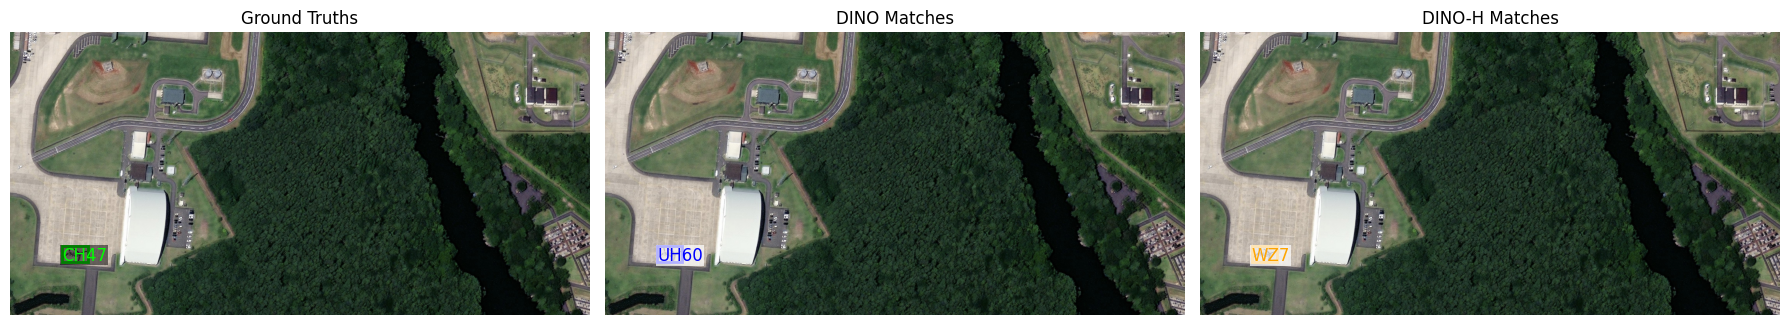


Visualizing best DINO-H case:


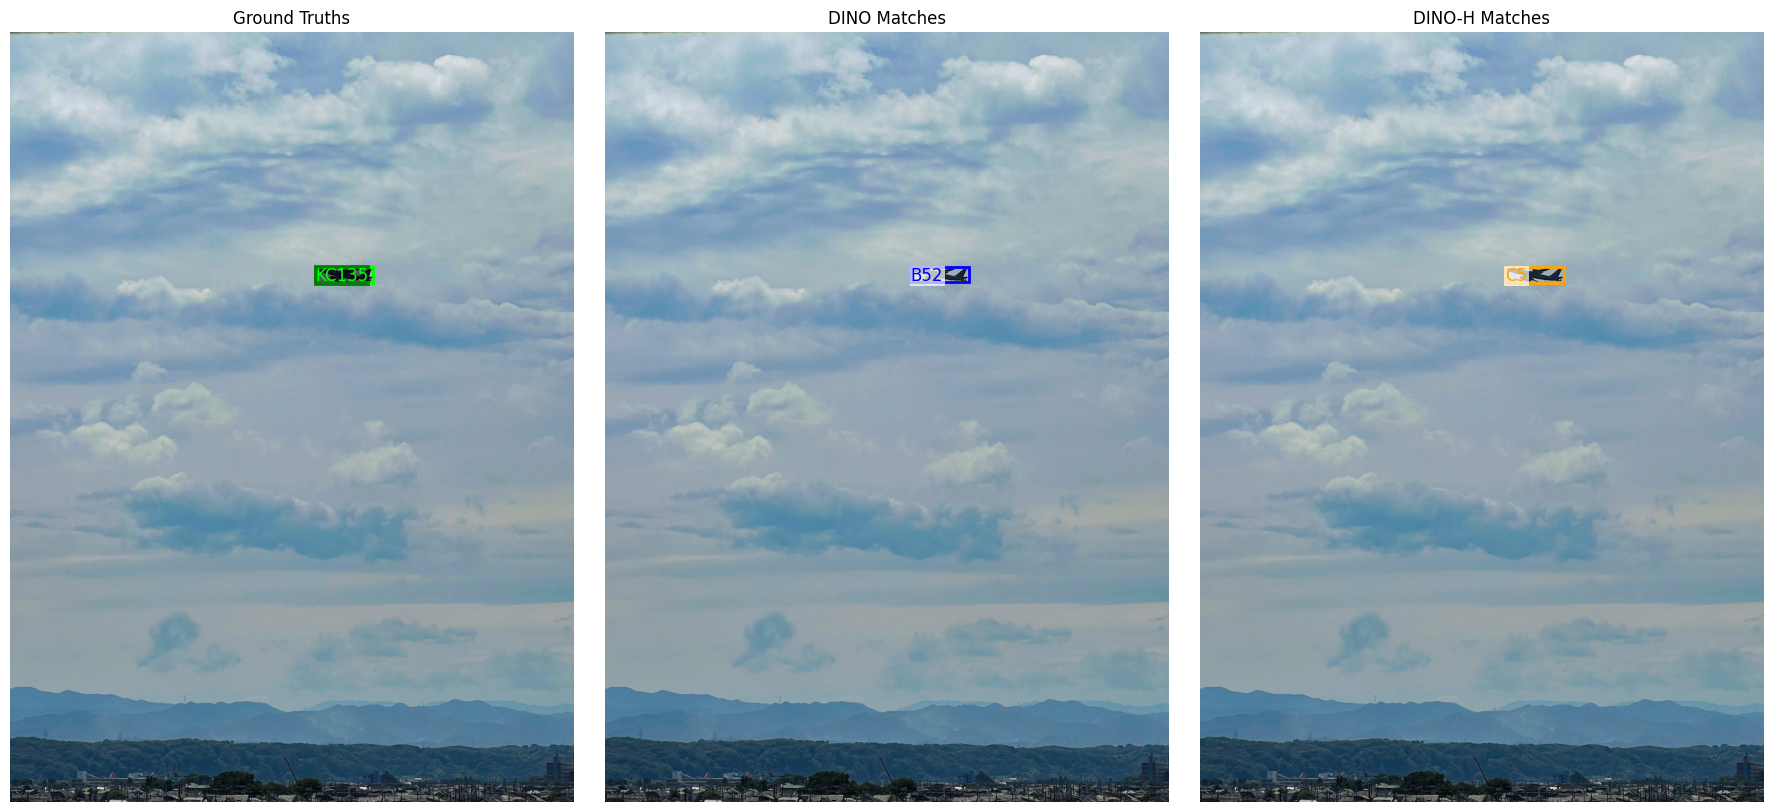

In [131]:
# Visualization: GT panel + one panel per model, each with all matches for that model
from matplotlib.patches import Rectangle

def draw_gt_and_models_panels(image_idx, df_merged, model_data, image_dir):
    import matplotlib.image as mpimg
    import os
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    img_info = model_data['DINO']['dataset'].get_data_info(int(image_idx))
    img_path = img_info.get('img_path', None)
    if img_path is None:
        print('Image path not found for idx', image_idx)
        return
    if not os.path.isabs(img_path):
        img_path = os.path.join(image_dir, img_path)
    img = mpimg.imread(img_path)
    img_h, img_w = img.shape[:2]
    gt_rows = df_merged[df_merged['image_idx'] == image_idx]
    def xyxy_to_xywh(bbox):
        if bbox is None or len(bbox) != 4:
            return None
        x1, y1, x2, y2 = bbox
        x = x1
        y = y1
        w = x2 - x1
        h = y2 - y1
        return [x, y, w, h]
    model_names = [k for k in model_data.keys()]
    n_panels = 1 + len(model_names)
    fig, axes = plt.subplots(1, n_panels, figsize=(6 * n_panels, 8))
    # GT panel (leftmost)
    ax = axes[0]
    ax.imshow(img)
    ax.set_title('Ground Truths')
    for _, row in gt_rows.iterrows():
        gt_bbox = xyxy_to_xywh(row['gt_bbox'])
        gt_label = row['gt_label']
        if gt_bbox is not None:
            x, y, w, h = gt_bbox
            rect = Rectangle((x, y), w, h, edgecolor='lime', facecolor='none', lw=2)
            ax.add_patch(rect)
            ax.text(x, y, f'{gt_label}', color='lime', fontsize=12, va='top', ha='left', bbox=dict(facecolor='black', alpha=0.5, pad=1, edgecolor='none'))
    ax.axis('off')
    colors = ['blue', 'orange', 'red', 'purple', 'cyan']
    for i, model_name in enumerate(model_names):
        ax = axes[i+1]
        ax.imshow(img)
        ax.set_title(f'{model_name} Matches')
        dt_bbox_col = f'dt_bbox_{model_name}'
        dt_label_col = f'dt_label_{model_name}'
        for _, row in gt_rows.iterrows():
            dt_bbox = xyxy_to_xywh(row.get(dt_bbox_col))
            dt_label = row.get(dt_label_col)
            if dt_bbox is not None and isinstance(dt_label, str):
                x, y, w, h = dt_bbox
                rect = Rectangle((x, y), w, h, edgecolor=colors[i % len(colors)], facecolor='none', lw=2)
                ax.add_patch(rect)
                ax.text(x, y, f'{dt_label}', color=colors[i % len(colors)], fontsize=12, va='top', ha='left', bbox=dict(facecolor='white', alpha=0.7, pad=1, edgecolor='none'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize GTs and predictions for the best and worst cases
image_dir = ''
print('\nVisualizing best DINO case:')
best_dino_row = sorted_df.head(1).iloc[0]
draw_gt_and_models_panels(best_dino_row['image_idx'], df_merged, model_data, image_dir)

print('\nVisualizing best DINO-H case:')
best_dinoh_row = sorted_df.tail(1).iloc[0]
draw_gt_and_models_panels(best_dinoh_row['image_idx'], df_merged, model_data, image_dir)


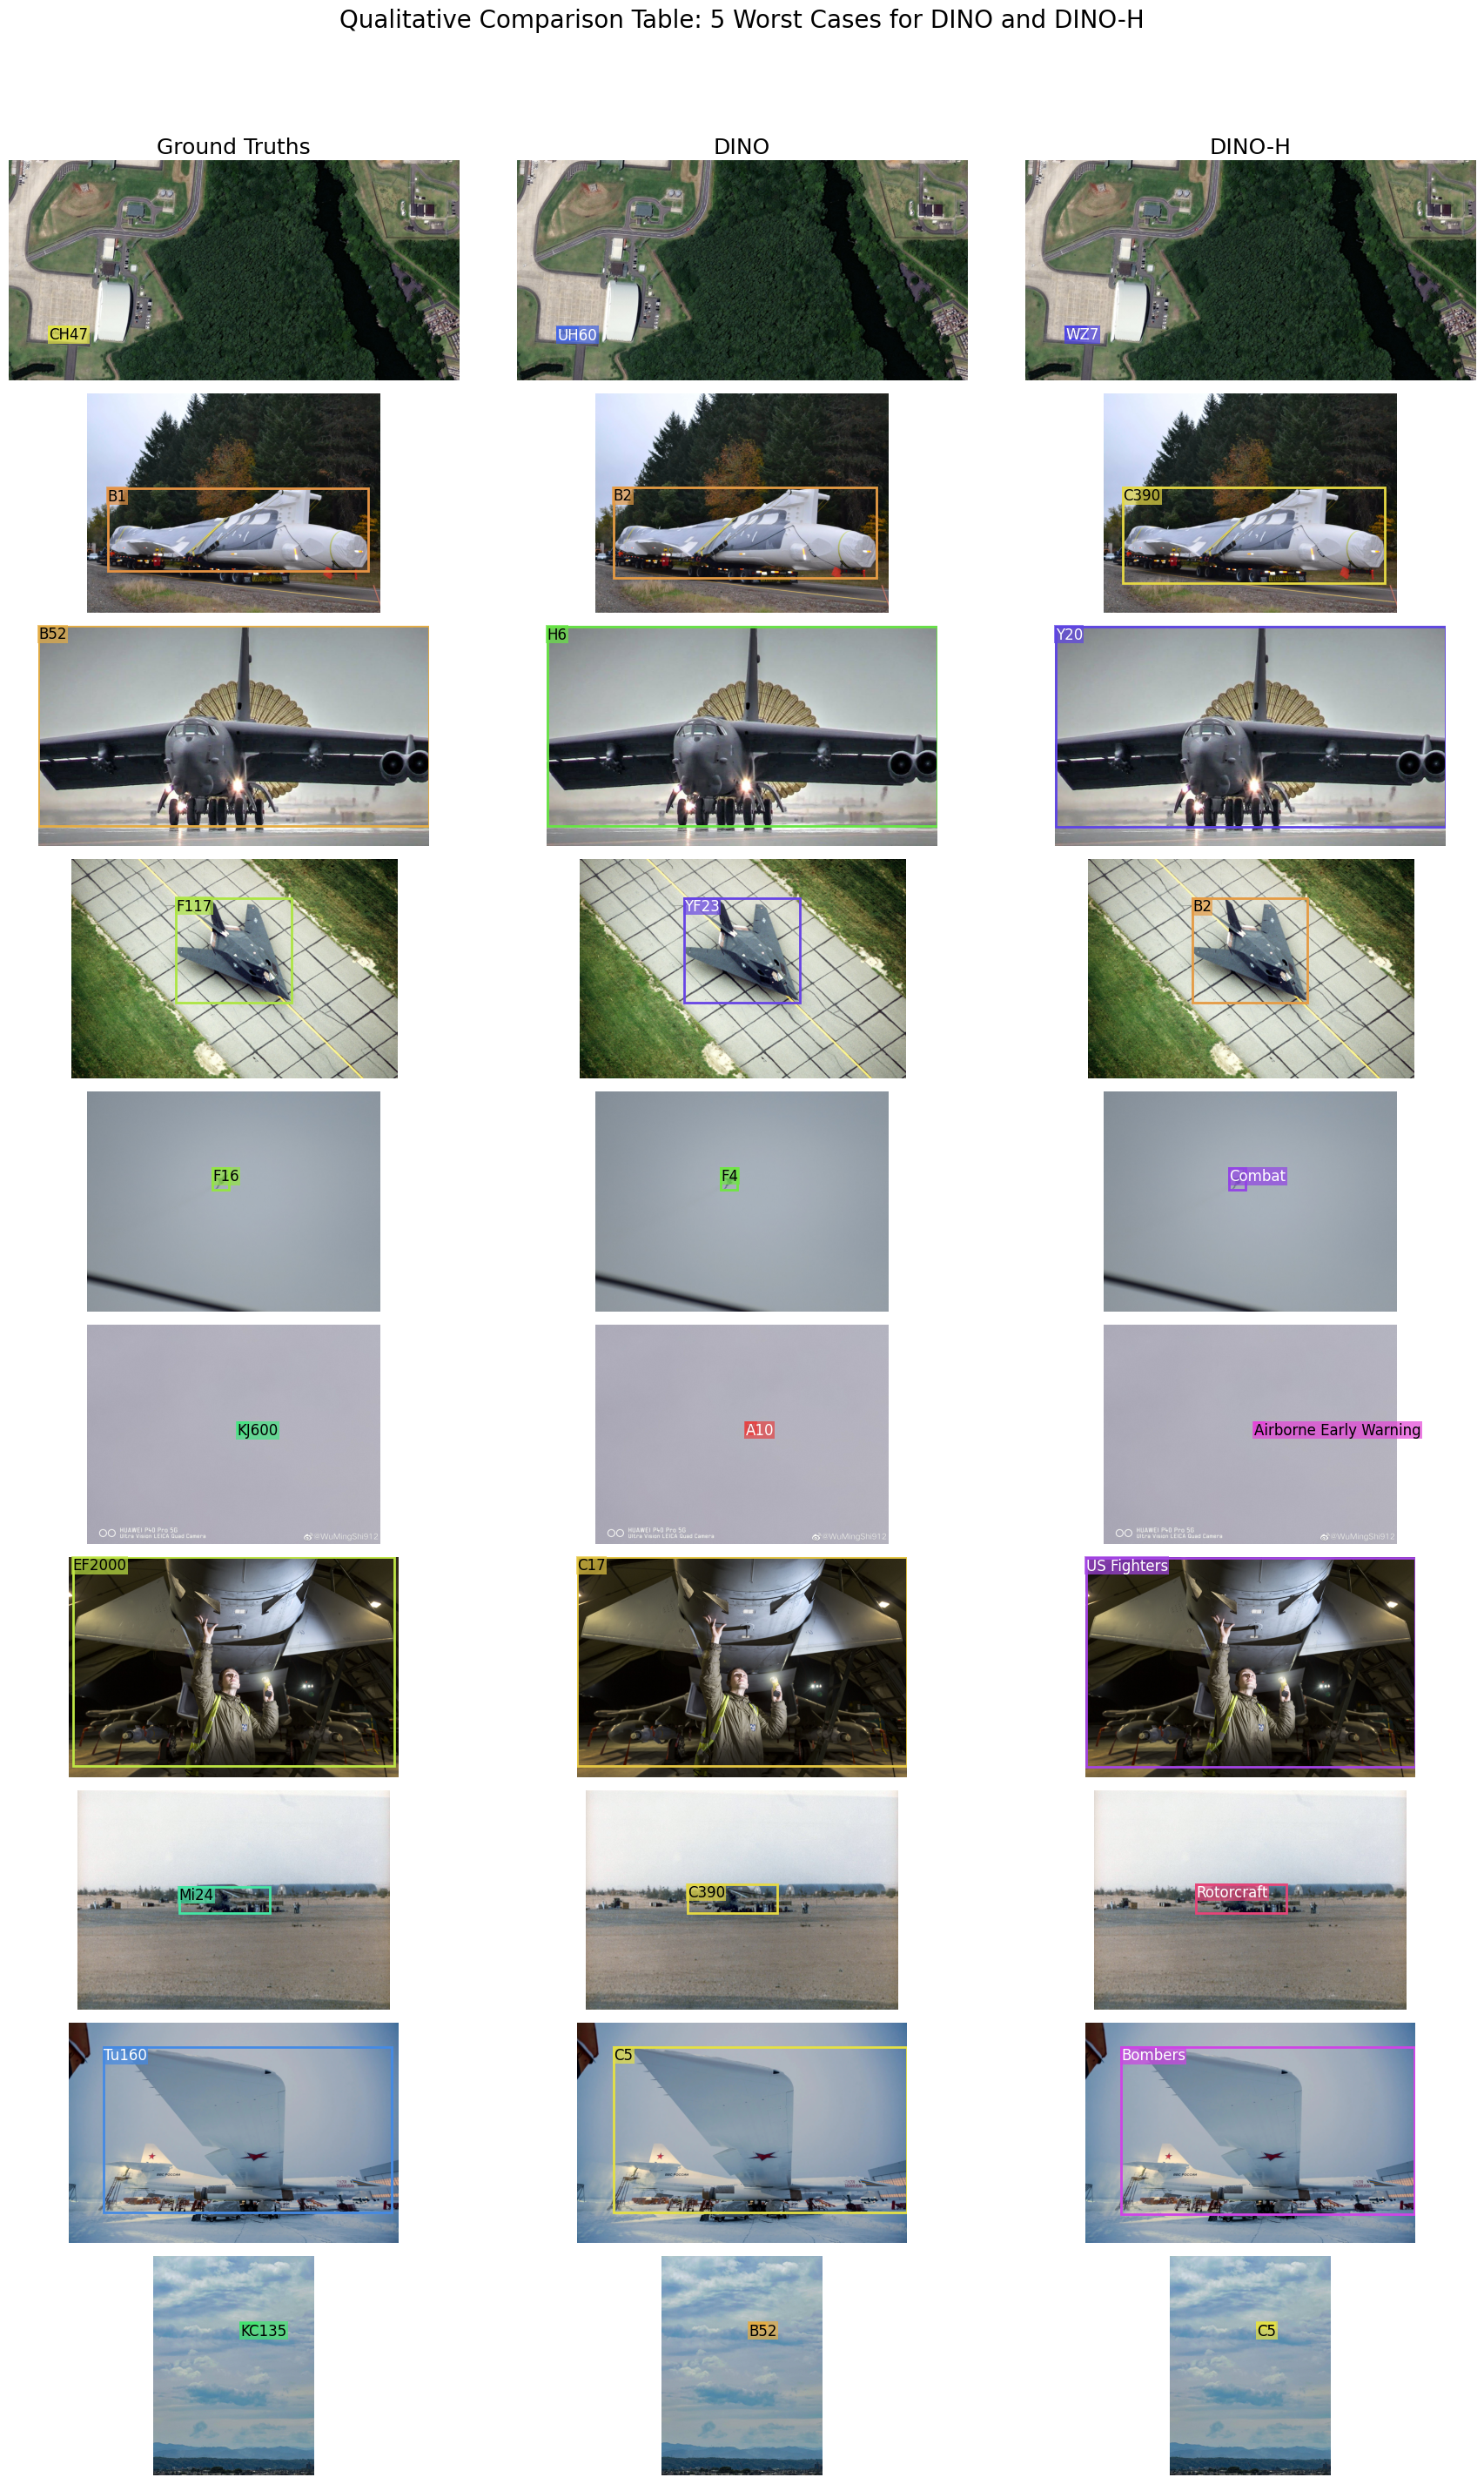

In [136]:
# Flexible table-style grid: show N worst cases per model (default N=2)
from matplotlib.patches import Rectangle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import colorsys

def get_taxonomy_colors(class_names):
    n = len(class_names)
    hsvs = [(i / n, 0.7, 0.9) for i in range(n)]
    rgbs = [colorsys.hsv_to_rgb(*hsv) for hsv in hsvs]
    return {name: tuple(int(255*x) for x in rgb) for name, rgb in zip(class_names, rgbs)}

def get_text_color(rgb):
    r, g, b = rgb
    luminance = (0.299*r + 0.587*g + 0.114*b)
    return 'white' if luminance < 128 else 'black'

def xyxy_to_xywh(bbox):
    if bbox is None or len(bbox) != 4:
        return None
    x1, y1, x2, y2 = bbox
    x = x1
    y = y1
    w = x2 - x1
    h = y2 - y1
    return [x, y, w, h]

def draw_table_panel(image_idx, df_merged, model_data, image_dir, axes, row_idx, taxonomy_colors):
    img_info = model_data['DINO']['dataset'].get_data_info(int(image_idx))
    img_path = img_info.get('img_path', None)
    if img_path is None:
        print('Image path not found for idx', image_idx)
        return
    if not os.path.isabs(img_path):
        img_path = os.path.join(image_dir, img_path)
    img = mpimg.imread(img_path)
    gt_rows = df_merged[df_merged['image_idx'] == image_idx]
    # GT panel (col 0)
    ax = axes[row_idx, 0]
    ax.imshow(img)
    for _, row in gt_rows.iterrows():
        gt_bbox = xyxy_to_xywh(row['gt_bbox'])
        gt_label = row['gt_label']
        if gt_bbox is not None and gt_label in taxonomy_colors:
            rgb = taxonomy_colors[gt_label]
            color = tuple(c/255 for c in rgb)
            text_color = get_text_color(rgb)
            x, y, w, h = gt_bbox
            rect = Rectangle((x, y), w, h, edgecolor=color, facecolor='none', lw=2)
            ax.add_patch(rect)
            ax.text(x, y, f'{gt_label}', color=text_color, fontsize=12, va='top', ha='left', bbox=dict(facecolor=color, alpha=0.7, pad=1, edgecolor='none'))
    ax.axis('off')
    # DINO panel (col 1)
    ax = axes[row_idx, 1]
    ax.imshow(img)
    dt_bbox_col = 'dt_bbox_DINO'
    dt_label_col = 'dt_label_DINO'
    for _, row in gt_rows.iterrows():
        dt_bbox = xyxy_to_xywh(row.get(dt_bbox_col))
        dt_label = row.get(dt_label_col)
        if dt_bbox is not None and isinstance(dt_label, str) and dt_label in taxonomy_colors:
            rgb = taxonomy_colors[dt_label]
            color = tuple(c/255 for c in rgb)
            text_color = get_text_color(rgb)
            x, y, w, h = dt_bbox
            rect = Rectangle((x, y), w, h, edgecolor=color, facecolor='none', lw=2)
            ax.add_patch(rect)
            ax.text(x, y, f'{dt_label}', color=text_color, fontsize=12, va='top', ha='left', bbox=dict(facecolor=color, alpha=0.7, pad=1, edgecolor='none'))
    ax.axis('off')
    # DINO-H panel (col 2)
    ax = axes[row_idx, 2]
    ax.imshow(img)
    dt_bbox_col = 'dt_bbox_DINO-H'
    dt_label_col = 'dt_label_DINO-H'
    for _, row in gt_rows.iterrows():
        dt_bbox = xyxy_to_xywh(row.get(dt_bbox_col))
        dt_label = row.get(dt_label_col)
        if dt_bbox is not None and isinstance(dt_label, str) and dt_label in taxonomy_colors:
            rgb = taxonomy_colors[dt_label]
            color = tuple(c/255 for c in rgb)
            text_color = get_text_color(rgb)
            x, y, w, h = dt_bbox
            rect = Rectangle((x, y), w, h, edgecolor=color, facecolor='none', lw=2)
            ax.add_patch(rect)
            ax.text(x, y, f'{dt_label}', color=text_color, fontsize=12, va='top', ha='left', bbox=dict(facecolor=color, alpha=0.7, pad=1, edgecolor='none'))
    ax.axis('off')

# Get taxonomy colors from DINO dataset
class_names = model_data['DINO']['dataset'].metainfo['classes']
taxonomy_colors = get_taxonomy_colors(class_names)

# Number of worst cases per model to show
N = 5

# Get N worst for DINO (highest positive diff) and N worst for DINO-H (highest negative diff)
worst_dino_rows = sorted_df.head(N)
worst_dinoh_rows = sorted_df.tail(N)

# Prepare grid: 2N rows, 3 columns
fig, axes = plt.subplots(2*N, 3, figsize=(18, 6*N))
plt.subplots_adjust(hspace=0.15, wspace=0.05)

# Set column headers only once
col_titles = ['Ground Truths', 'DINO', 'DINO-H']
for i, title in enumerate(col_titles):
    axes[0, i].set_title(title, fontsize=18)
    for r in range(1, 2*N):
        axes[r, i].set_title('')

# Fill rows for DINO worst cases
for idx, row in enumerate(worst_dino_rows.itertuples()):
    draw_table_panel(row.image_idx, df_merged, model_data, image_dir, axes, idx, taxonomy_colors)
    axes[idx,0].set_ylabel(f'DINO Worst Case {idx+1}', fontsize=16)

# Fill rows for DINO-H worst cases
for idx, row in enumerate(worst_dinoh_rows.itertuples()):
    draw_table_panel(row.image_idx, df_merged, model_data, image_dir, axes, N+idx, taxonomy_colors)
    axes[N+idx,0].set_ylabel(f'DINO-H Worst Case {idx+1}', fontsize=16)

plt.suptitle(f'Qualitative Comparison Table: {N} Worst Cases for DINO and DINO-H', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

GT crops for DINO Worst Case 1 (image_idx=796):


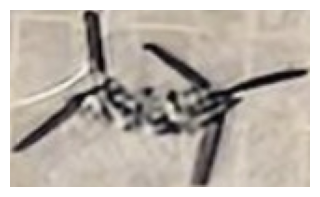

GT crops for DINO Worst Case 2 (image_idx=683):


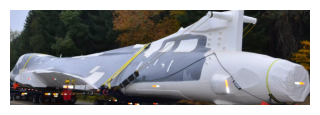

GT crops for DINO Worst Case 3 (image_idx=652):


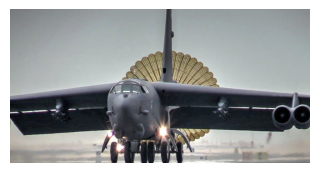

GT crops for DINO Worst Case 4 (image_idx=914):


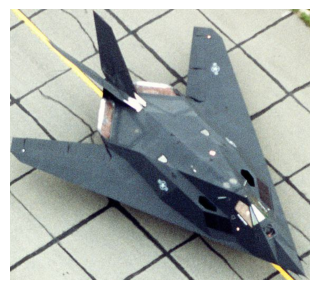

GT crops for DINO Worst Case 5 (image_idx=1239):


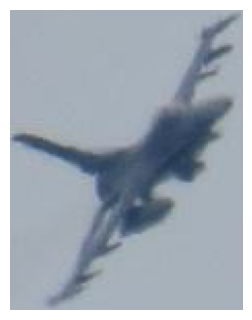

GT crops for DINO-H Worst Case 1 (image_idx=99):


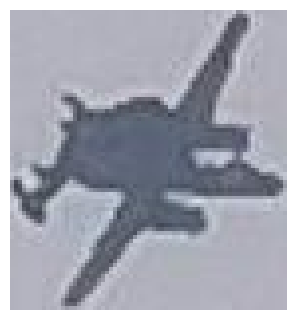

GT crops for DINO-H Worst Case 2 (image_idx=514):


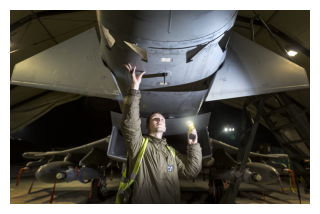

GT crops for DINO-H Worst Case 3 (image_idx=557):


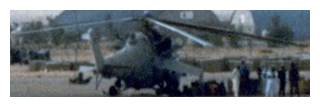

GT crops for DINO-H Worst Case 4 (image_idx=274):


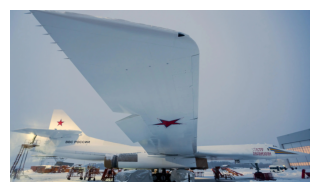

GT crops for DINO-H Worst Case 5 (image_idx=886):


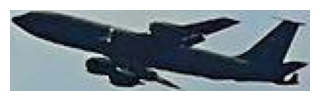

In [141]:
# Visualize only GT crops for the worst hierarchical errors (no labels, no border, no extra padding)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def crop_and_show_gt(image_idx, df_merged, model_data, image_dir):
    img_info = model_data['DINO']['dataset'].get_data_info(int(image_idx))
    img_path = img_info.get('img_path', None)
    if img_path is None:
        print('Image path not found for idx', image_idx)
        return
    if not os.path.isabs(img_path):
        img_path = os.path.join(image_dir, img_path)
    img = mpimg.imread(img_path)
    gt_rows = df_merged[df_merged['image_idx'] == image_idx]
    crops = []
    for _, row in gt_rows.iterrows():
        gt_bbox = row['gt_bbox']
        if gt_bbox is not None:
            x1, y1, x2, y2 = [int(round(v)) for v in gt_bbox]
            crop = img[y1:y2, x1:x2]
            crops.append(crop)
    n = len(crops)
    if n == 0:
        print('No GT crops found for image', image_idx)
        return
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    if n == 1:
        axes = [axes]
    for i, crop in enumerate(crops):
        axes[i].imshow(crop)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout(pad=0)
    plt.show()

# Show GT crops for the N worst DINO and DINO-H cases
for idx, row in enumerate(worst_dino_rows.itertuples()):
    print(f'GT crops for DINO Worst Case {idx+1} (image_idx={row.image_idx}):')
    crop_and_show_gt(row.image_idx, df_merged, model_data, image_dir)
    
for idx, row in enumerate(worst_dinoh_rows.itertuples()):
    print(f'GT crops for DINO-H Worst Case {idx+1} (image_idx={row.image_idx}):')
    crop_and_show_gt(row.image_idx, df_merged, model_data, image_dir)